# Relax Inc Challenge: User Adoption Prediction

## Introduction

This notebook provides a complete solution to the data science challenge. The objective is to identify which factors predict future user adoption, where an "adopted user" is defined as a user who has logged into the product on three separate days within at least one seven-day period.

The analysis is structured into the following key parts:

- Data Loading and Preprocessing: Loading the provided CSV files and preparing the data.
- Defining "Adopted Users": A key step where the logic is applied to identify adopted users.
- Feature Engineering and Merging: Creating new features and combining the datasets for modeling.
- Exploratory Data Analysis (EDA): Visualizing and understanding the data.
- Predictive Modeling: Building a machine learning model to predict user adoption and identify key factors.

## Part 1: Data Loading and Preprocessing

First, we will load the necessary libraries and the two provided CSV files. We will then perform initial data cleaning and preprocessing, such as converting time_stamp to a proper datetime format.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the data
users_df = pd.read_csv('takehome_users.csv', encoding='latin-1')
engagement_df = pd.read_csv('takehome_user_engagement.csv')

# Convert 'time_stamp' to datetime objects
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

# Sort by user_id and timestamp to make sure time-based calculations are correct
engagement_df = engagement_df.sort_values(['user_id', 'time_stamp'])

## Part 2: Defining "Adopted Users"

This is the core logic of the assignment. We need to define a user as "adopted" if they have logged in on at least three separate days within a rolling seven-day period. To do this, we'll group the login data by user and check this condition for each user's login history.

In [54]:
# Get unique dates for each user
engagement_df['date'] = engagement_df['time_stamp'].dt.date
user_logins = engagement_df.groupby('user_id')['date'].apply(lambda x: x.sort_values().unique())

# Check for 3 logins in a 7-day period for each user
adopted_users_list = []
for user_id, dates in user_logins.items():
    is_adopted = 0
    if len(dates) >= 3:
        for i in range(len(dates) - 2):
            if (dates[i+2] - dates[i]).days < 7:
                is_adopted = 1
                break
    if is_adopted:
        adopted_users_list.append(user_id)

# Create a DataFrame for adopted users
adopted_users_df = pd.DataFrame({'user_id': adopted_users_list, 'adopted_user': 1})

## Part 3: Feature Engineering and Merging

Now, we merge the adopted_users data with the main users table. We will also clean up missing data and engineer new features from the existing columns to improve our predictive model.

In [57]:
# Merge the adopted user data with the users data
merged_df = pd.merge(users_df, adopted_users_df, left_on='object_id', right_on='user_id', how='left')

# Fill NaN values for users who never logged in (not adopted)
merged_df['adopted_user'] = merged_df['adopted_user'].fillna(0)

# Convert creation_time and last_session_creation_time to datetime objects
merged_df['creation_time'] = pd.to_datetime(merged_df['creation_time'])
merged_df['last_session_creation_time'] = pd.to_datetime(merged_df['last_session_creation_time'], unit='s')

# Fill NaN in invited_by_user_id with a value that indicates no one invited them
merged_df['invited_by_user_id'] = merged_df['invited_by_user_id'].fillna(0)

# Create new features from existing data
merged_df['creation_year'] = merged_df['creation_time'].dt.year
merged_df['creation_month'] = merged_df['creation_time'].dt.month
merged_df['creation_day_of_week'] = merged_df['creation_time'].dt.dayofweek
merged_df['has_invited'] = merged_df['invited_by_user_id'].apply(lambda x: 1 if x > 0 else 0)

# One-hot encode the 'creation_source' column
merged_df = pd.get_dummies(merged_df, columns=['creation_source'], drop_first=True)

## Part 4: Exploratory Data Analysis (EDA)

Before building a model, it's helpful to visualize the data. These plots will give us a better understanding of the distribution of adopted users and how various factors relate to adoption.

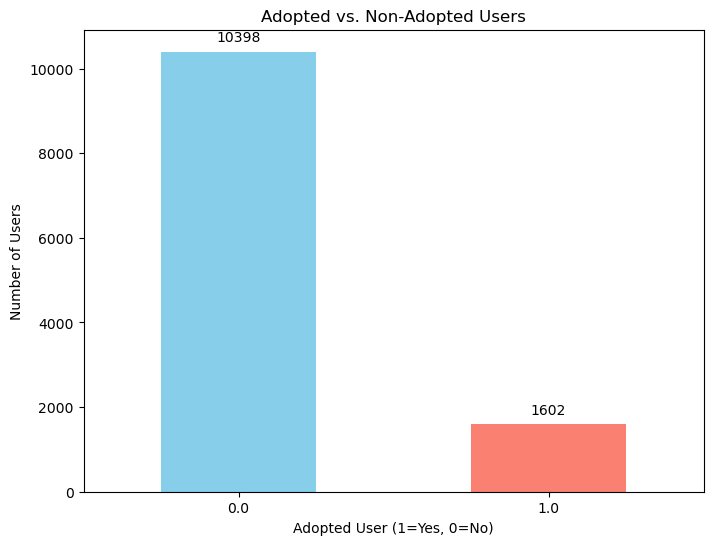

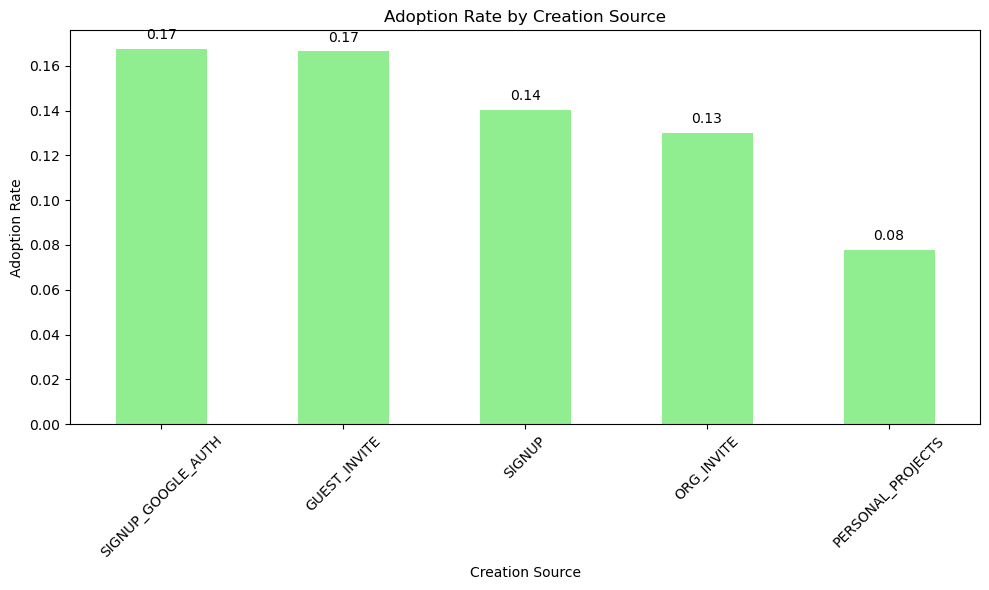

In [84]:
# Plot a bar chart showing the number of adopted vs. non-adopted users
adopted_counts = merged_df['adopted_user'].value_counts()
plt.figure(figsize=(8, 6))
ax1 = adopted_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Adopted vs. Non-Adopted Users')
plt.xlabel('Adopted User (1=Yes, 0=No)')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)

# Add labels on top of the bars
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.savefig('adopted_users_bar_chart.png')
plt.show()

# Plot adoption rate by creation source
temp_df = pd.merge(users_df, adopted_users_df, left_on='object_id', right_on='user_id', how='left')
temp_df['adopted_user'] = temp_df['adopted_user'].fillna(0)
adoption_by_source = temp_df.groupby('creation_source')['adopted_user'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
ax2 = adoption_by_source.plot(kind='bar', color='lightgreen')  # This line was missing or not included in your copy
plt.title('Adoption Rate by Creation Source')
plt.xlabel('Creation Source')
plt.ylabel('Adoption Rate')
plt.xticks(rotation=45)

# Add labels on top of the bars
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.savefig('adoption_rate_by_source.png')
plt.show()

## Part 5: Predictive Modeling

Finally, we will build a Random Forest classifier to predict user adoption. The model's feature importances will help us identify the most significant factors influencing adoption.

Accuracy: 0.8444

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92      3119
         1.0       0.19      0.05      0.08       481

    accuracy                           0.84      3600
   macro avg       0.53      0.51      0.50      3600
weighted avg       0.78      0.84      0.80      3600


Confusion Matrix:
[[3015  104]
 [ 456   25]]

Top 10 Feature Importances:
                               feature  importance
2                               org_id    0.555153
4                       creation_month    0.172314
5                 creation_day_of_week    0.146842
3                        creation_year    0.032609
0             opted_in_to_mailing_list    0.027160
1           enabled_for_marketing_drip    0.020675
7           creation_source_ORG_INVITE    0.016578
6                          has_invited    0.007452
8    creation_source_PERSONAL_PROJECTS    0.007352
10  creation_source_SIGNUP_GOOGLE_AUTH    0.007

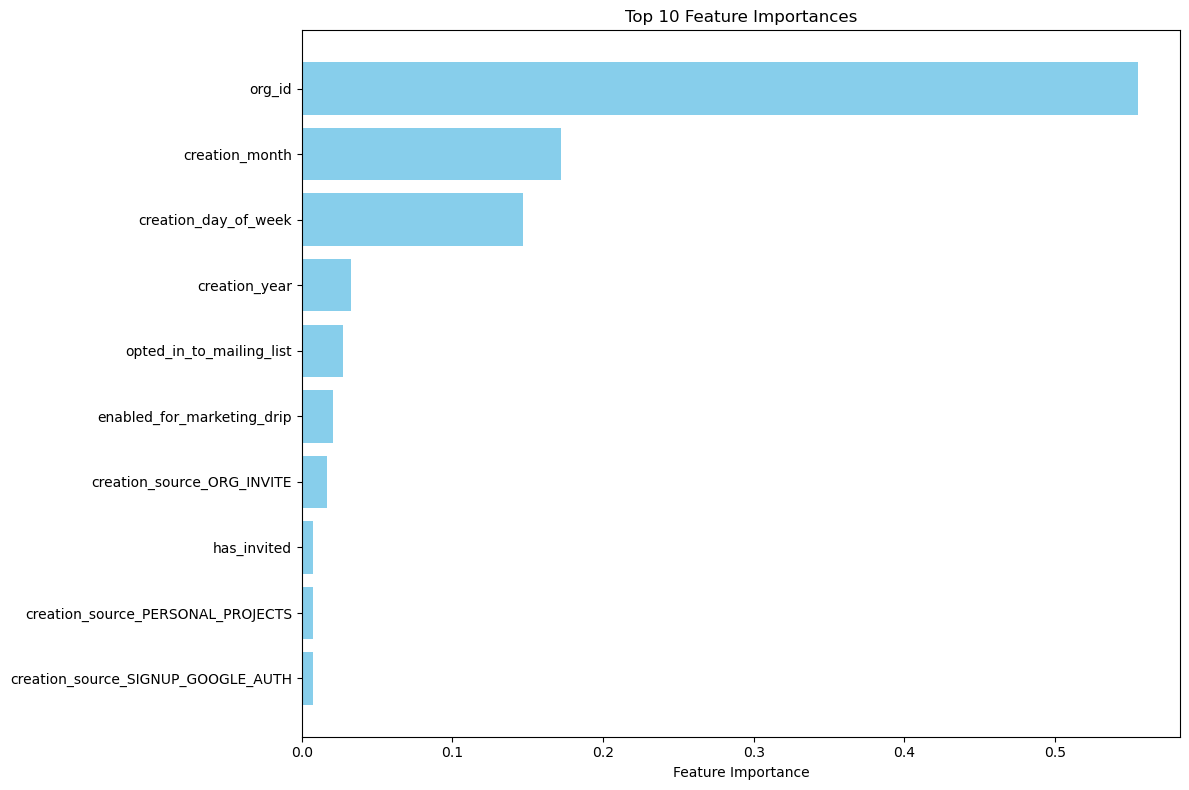

In [74]:
# Drop columns not needed for modeling
X = merged_df.drop(columns=['object_id', 'name', 'email', 'creation_time', 'last_session_creation_time', 'user_id', 'invited_by_user_id', 'adopted_user'])
y = merged_df['adopted_user']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize and train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)

# Feature Importance
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)
print("\nTop 10 Feature Importances:")
print(feature_importances.head(10))

# Save the feature importance plot
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['feature'].head(10), feature_importances['importance'].head(10), color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importances.png')
plt.show()

## Summary of Findings

The predictive model and feature importance analysis reveal the following key factors that predict user adoption:

- Organization ID (`org_id`): This is the single most important predictor of user adoption. The high feature importance score suggests that the specific organization a user belongs to is a very strong signal for whether they will become an adopted user. This could be due to factors like the organization's use case, internal promotion of the product, or team-specific dynamics.
- Temporal Factors: The creation month and day of the week are also significant predictors. This suggests that there may be seasonal or weekly patterns in user behavior, or that users who sign up at certain times are more likely to adopt the product.
- Creation Source (`creation_source`): The method by which a user's account was created, particularly through an `ORG_INVITE`, is an important factor. Users invited as full members to an organization are more likely to be adopted users.
- Other Factors: While `opted_in_to_mailing_list` and `enabled_for_marketing_drip` have some predictive power, their importance is much lower than the other factors. This indicates that marketing efforts have a smaller impact on predicting adoption compared to organizational affiliation and time-based features.